### K Means clustering classification (unsupervised learning) on hacker data

In [3]:
from pyspark.sql import SparkSession, functions
import warnings
warnings.filterwarnings('ignore')

In [4]:
spark = SparkSession.builder.appName("stock_price_analysis").getOrCreate()

In [5]:
df = spark.read.csv("hack_data.csv", header=True, inferSchema=True)

In [6]:
df.show(2)

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
only showing top 2 rows



In [11]:
df.describe().toPandas()

,summary,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,Location,WPM_Typing_Speed
0,count,334,334,334,334,334,334,334
1,mean,30.008982035928145,607.2452694610777,0.5119760479041916,5.258502994011977,10.838323353293413,None,57.342395209580864
2,stddev,14.088200614636158,286.33593163576757,0.5006065264451406,2.30190693339697,3.06352633036022,None,13.41106336843464
3,min,1.0,10.0,0,1.0,6.0,Afghanistan,40.0
4,max,60.0,1330.5,1,10.0,15.0,Zimbabwe,75.0


In [13]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [14]:
df.columns

['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location',
 'WPM_Typing_Speed']

In [15]:
feat_cols = ['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'WPM_Typing_Speed']

In [16]:
assembler = VectorAssembler(inputCols=feat_cols, outputCol='features')

In [18]:
final_df = assembler.transform(df)

In [19]:
from pyspark.ml.feature import StandardScaler

In [20]:
scaler = StandardScaler(inputCol='features', 
                        outputCol='scaled_feat',
                        withStd=True,
                       withMean=False)

In [21]:
scaled_model = scaler.fit(final_df)

In [22]:
cluster_df = scaled_model.transform(final_df)

In [24]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [25]:
eval = ClusteringEvaluator(predictionCol="prediction",
                          featuresCol="scaled_feat",
                          metricName="silhouette",
                          distanceMeasure="squaredEuclidean")

In [26]:
silhouette_score = []
print("""
Silhouette scores for K Means Clustering
========================================
Model\tScore\t
=====\t=====\t
""")
for k in range(2,11):
    kmeans_algo = KMeans(featuresCol='scaled_feat', k=k)
    kmeans_fit = kmeans_algo.fit(cluster_df)
    output = kmeans_fit.transform(cluster_df)
    score = eval.evaluate(output)
    silhouette_score.append(score)
    print(f"K{k}\t{round(score,2)}\t")


Silhouette scores for K Means Clustering
Model	Score	
=====	=====	

K2	0.82	
K3	0.76	
K4	0.72	
K5	0.66	
K6	0.55	
K7	0.63	
K8	0.39	
K9	0.39	
K10	0.44	


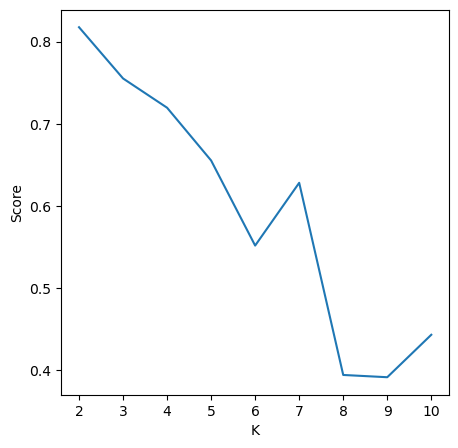

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(range(2,11), silhouette_score)
ax.set_xlabel("K")
ax.set_ylabel("Score");